Biblioteki:

In [13]:
from __future__ import print_function
import numpy as np
import scipy as scipy

%matplotlib notebook
import matplotlib.pyplot as plt

import openpyxl
from mpmath import mp
import math
import openpyxl
from matplotlib import rcParams
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from scipy.integrate import odeint
from collections import OrderedDict
from scipy.stats import norm
from lmfit import Parameters, Model
from lmfit.models import GaussianModel

from scipy import optimize
from scipy.optimize import curve_fit

from scipy.misc import electrocardiogram
from scipy.signal import find_peaks
from scipy.stats import linregress

import cv2
import heartpy as hp


import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve
import statistics

import pandas as pd
from openpyxl import load_workbook

dtype=np.float32

Funkcja odpowiedzialna za odczyt zespołu QRS zapisamego w .xlsx:

In [14]:
def get_ecg_data(path):
    # workbook object is created
    wb_obj = openpyxl.load_workbook(path)

    sheet_obj = wb_obj.active
    max_col = sheet_obj.max_column
    m_row = sheet_obj.max_row
    ecg_signal = []
    for i in range(2, m_row + 1):
        cell_obj = sheet_obj.cell(row=i, column=3)
        # print(cell_obj.value)
        ecg_signal.append(cell_obj.value)

    return ecg_signal

Podanie sciezki do pliku z RBBB:

In [15]:
path = "D:/MedApp/HeartAnalysis_with_gui/210_Exel_RBBB/210_93384.xlsx"

<IPython.core.display.Javascript object>


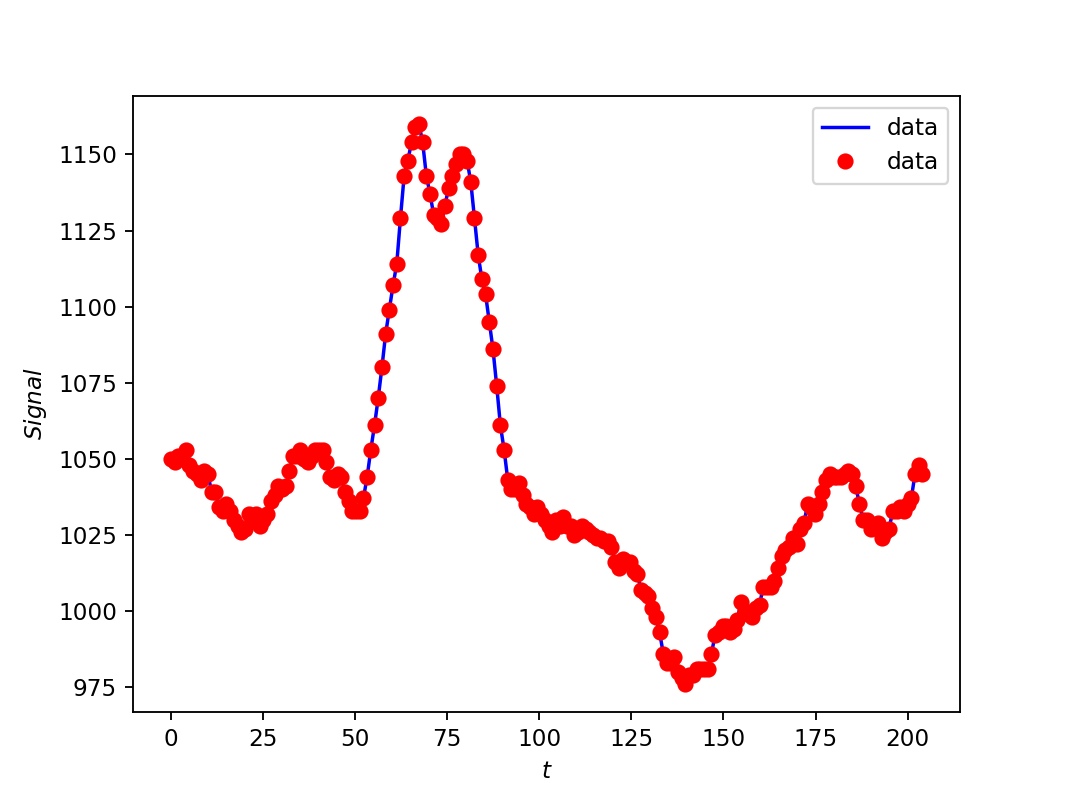

In [17]:
ecg_signal= get_ecg_data(path)
t_min = 0
t_max = len(ecg_signal)
t_original_signal = np.linspace(t_min, t_max, len(ecg_signal))
y_original_signal =  np.array(get_ecg_data(path))

#plt.plot(t_original_signal, y_original_signal-1012, 'b', label='data')
plt.plot(t_original_signal, y_original_signal, 'b', label='data')
#plt.plot(t_original_signal, y_original_signal-1012, 'or', label='data')
plt.plot(t_original_signal, y_original_signal, 'or', label='data')
plt.xlabel('$t$')
plt.ylabel('$Signal$')
plt.legend()
plt.show()

Usunięcie Wander Line:

In [18]:
filtered = hp.remove_baseline_wander(y_original_signal, 1000)

Wyrownanie jak najblizej zera

In [19]:
val =0.5*(y_original_signal[0]+y_original_signal[t_max-1])
filtered_signal= y_original_signal-val

szukamy pika:

In [20]:
peaks, _ = find_peaks(filtered_signal, height=0.4 * max(filtered_signal))
print(peaks)

[67 78]


Wybór PIKÓW: wybieramy dwa skrajne:

In [21]:
indeksy_pikow=sorted(filtered_signal[peaks])

Sprawdzenie ilości pików:

In [22]:
amount_peaks = len(indeksy_pikow)

mamy wiecej niż jeden pik!
indesky pikow:  [102.5, 112.5]
znaleziony pik: 67.000000   wartosc w piku: 102.500000 
znaleziony pik: 78.000000   wartosc w piku: 112.500000 


<IPython.core.display.Javascript object>


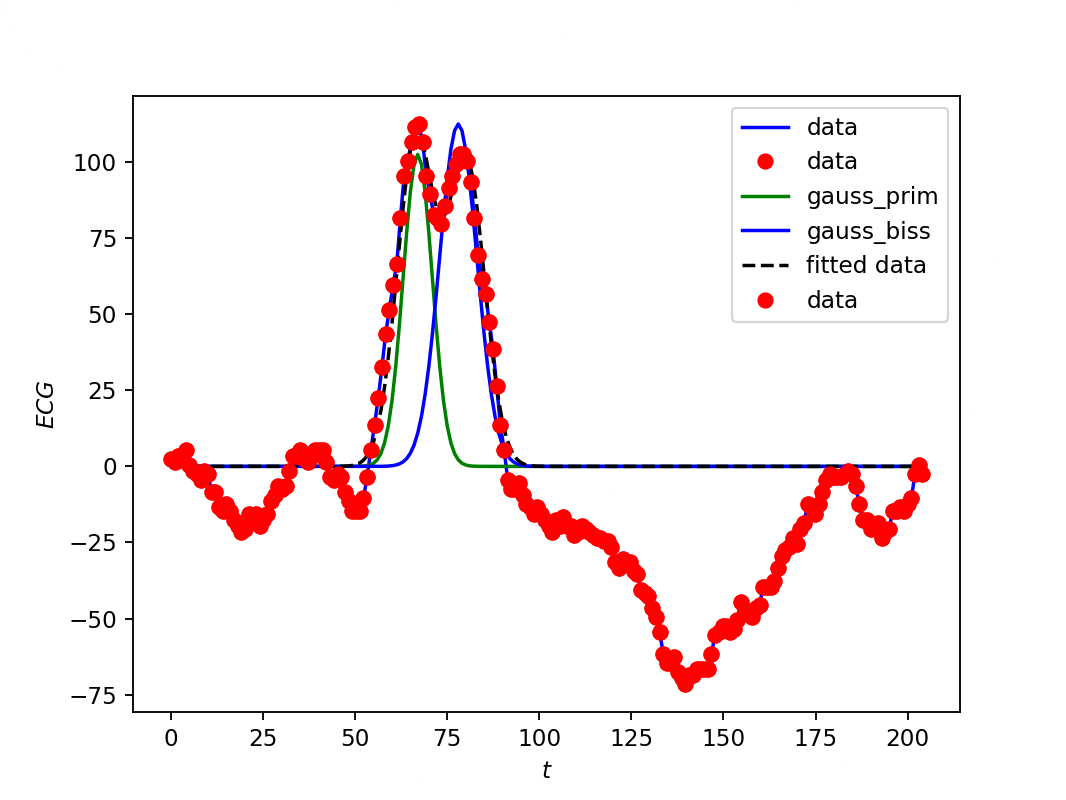

Gaussian 1:
[107.14440738   7.13515465  66.47980564]
Gaussian 2:
[99.908267    7.10300008 80.18820685]
Wykryto RBBB !!!


In [23]:
if(amount_peaks) >1:
    print("mamy wiecej niż jeden pik!")
    print("indesky pikow: ", indeksy_pikow)
    print('znaleziony pik: %f   wartosc w piku: %f ' % (peaks[0], indeksy_pikow[0]))
    print('znaleziony pik: %f   wartosc w piku: %f ' % (peaks[-1], indeksy_pikow[-1]))

    plt.plot(t_original_signal, filtered_signal, 'b', label='data')
    plt.xlabel('$t$')
    plt.ylabel('$Signal$')
    plt.legend()
    plt.show()

    # Stworzenie gaussow:

    # zespol ,,nr 1"
    amp1 = indeksy_pikow[0]
    cen1 = 5.60
    sigma1 = peaks[0]

    # zespol ,,nr 2"
    amp2 = indeksy_pikow[-1]
    cen2 = 7.20
    sigma2 = peaks[-1]


    def _1gaussian(x, amp, cen, sigma):
        return amp * np.exp(-((x - sigma) / cen) ** 2)


    x_array = np.linspace(1, len(ecg_signal), len(ecg_signal))
    data_gauss_1 = _1gaussian(x_array, amp1, cen1, sigma1)

    data_gauss_2 = _1gaussian(x_array, amp2, cen2, sigma2)

    plt.plot(t_original_signal, filtered_signal, 'or', label='data')
    plt.plot(x_array, data_gauss_1, 'g', label='gauss_prim')
    plt.plot(x_array, data_gauss_2, 'b', label='gauss_biss')
    # plt.plot(t_train, gauss_triple_mniejsze, 'g', label='gauss_mniejszy')
    plt.xlabel('$t$')
    plt.ylabel('$ECG$')
    plt.legend()
    plt.show()


    def _2gaussian(x, amp1, cen1, sigma1, amp2, cen2, sigma2):
        return amp1 * np.exp(-((x - sigma1) / cen1) ** 2) + amp2 * np.exp(-((x - sigma2) / cen2) ** 2)


    popt_2gauss, pcov_2gauss = scipy.optimize.curve_fit(_2gaussian, x_array, filtered_signal,
                                                        p0=[amp1, cen1, sigma1, amp2, cen2, sigma2])
    perr_2gauss = np.sqrt(np.diag(pcov_2gauss))
    pars_1 = popt_2gauss[0:3]
    pars_2 = popt_2gauss[3:6]
    gauss_peak_1 = _1gaussian(x_array, *pars_1)
    gauss_peak_2 = _1gaussian(x_array, *pars_2)

    plt.plot(x_array, _2gaussian(x_array, *popt_2gauss), 'k--', label='fitted data')
    plt.plot(t_original_signal, filtered_signal, 'or', label='data')

    plt.xlabel('$t$')
    plt.ylabel('$ECG$')
    plt.legend()
    plt.show()

    print("Gaussian 1:")
    print(pars_1)

    print("Gaussian 2:")
    print(pars_2)

    if pars_1[1]>5 or pars_2[1]>5:
        print("Wykryto RBBB !!!")

        #Wartości do zapisania w formie wykressu

        x_values=[indeksy_pikow[0],indeksy_pikow[-1] ]
        centroid_values =[popt_2gauss[1], popt_2gauss[4]]
        amplitude_values = [popt_2gauss[0], popt_2gauss[3]]




        #data_to_save = {'Index values': x_values, 'Cetroid Values': centroid_values, 'Amplituda': amplitude_values}
        #df = pd.DataFrame(data_to_save)
        #file_name = "D:/MedApp/HeartAnalysis_with_gui/Wyniki_RBBB_1.xlsx"
        # saving the excel
        #df.to_excel(file_name)



    else:
        print("nie wykryto LBBB")


else:
    print("nie wykryto LBBB")